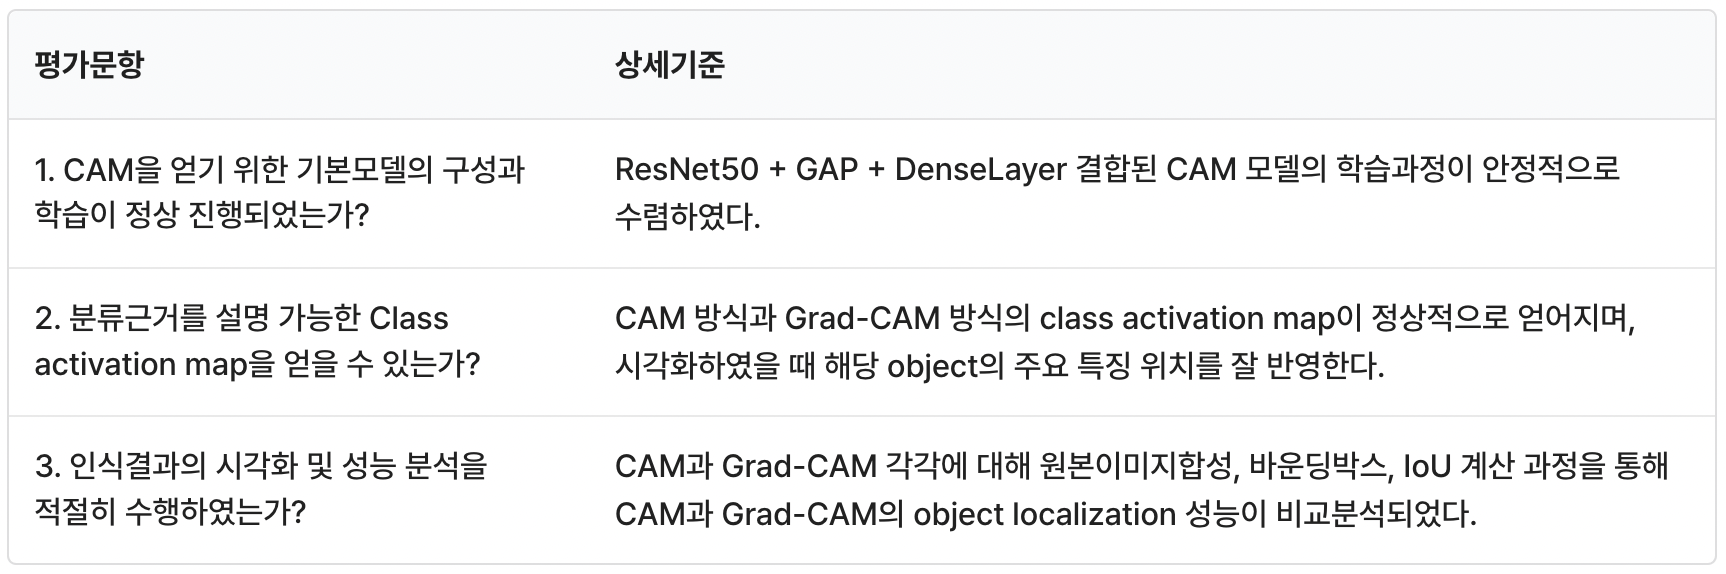

## 필요 라이브러리 import 및 환경 세팅

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow_datasets as tfds

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


import copy
import cv2
from PIL import Image

import os


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 데이터 로딩 및 전처리

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    download=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


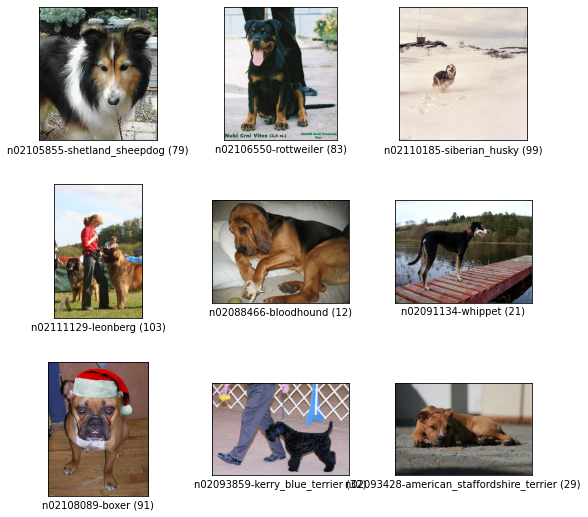

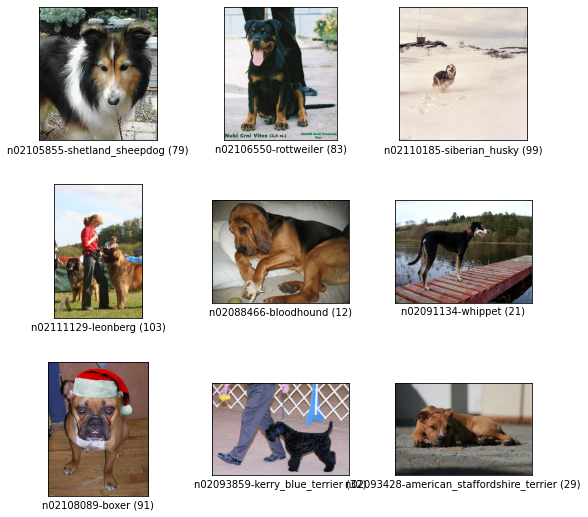

In [4]:
tfds.show_examples(ds_train, ds_info)

In [5]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [6]:
ds_train

<_OptionsDataset shapes: {image: (None, None, 3), image/filename: (), label: (), objects: {bbox: (None, 4)}}, types: {image: tf.uint8, image/filename: tf.string, label: tf.int64, objects: {bbox: tf.float32}}>

In [7]:
example = ds_train.take(1)

In [8]:
for sample in example:
    print(sample['image'].shape)
#     print(sample['image'])
    image = tf.reshape(sample['image'],shape=(-1,3))
    image = tf.cast(image, tf.float32)
    print(tf.math.reduce_mean(image, 0)) 
    print(tf.math.reduce_std(image, 0))    

(333, 500, 3)
tf.Tensor([136.52362  101.53379   65.940475], shape=(3,), dtype=float32)
tf.Tensor([37.15499  43.684166 46.965504], shape=(3,), dtype=float32)


In [9]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())    
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

79


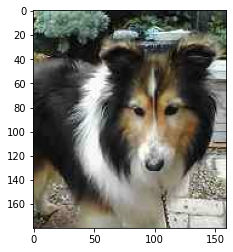

In [10]:
item = get_one(ds_train)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [11]:
def normalize_and_resize_img(input):
    # resize
    image = tf.image.resize(input['image'], [224,224])
    image = tf.cast(image, tf.float32)
#     print(image.shape)
    
    # normalize
    image_reshaped = tf.reshape(image,shape=(-1,3))
    image_mean = tf.math.reduce_mean(image_reshaped, 0)
    image_std = tf.math.reduce_std(image_reshaped, 0)
    image = (image - image_mean)/image_std
#     print(image.shape)
#     print(image)
#     print(image_mean)
#     print(image_std)
    input['image'] = (image - image_mean)/image_std

    
    return input['image'], input['label']

In [12]:
def normalize_and_resize_img_1(input):
    # resize
    image = tf.image.resize(input['image'], [224,224])
    image = tf.cast(image, tf.float32)
#     print(image)
    
    # normalize
    input['image'] = image/255.
    
    return input['image'], input['label']

In [13]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(normalize_and_resize_img,
               num_parallel_calls=2)
    
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [14]:
def apply_normalize_on_dataset_1(ds, is_test=False, batch_size=16):
    ds = ds.map(normalize_and_resize_img_1,
               num_parallel_calls=2)
    
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [15]:
ds_train_norm = apply_normalize_on_dataset(ds_train)

In [16]:
ds_test_norm = apply_normalize_on_dataset(ds_test, is_test=True)

In [17]:
ds_train_norm_1 = apply_normalize_on_dataset_1(ds_train)

In [18]:
ds_test_norm_1 = apply_normalize_on_dataset_1(ds_test, is_test=True)

## CAM 구현하기
1. 이번 노드에 나왔던 CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.
2. 만든 함수로 CAM 이미지를 생성합시다.
3. 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수를 만들어보세요.

In [23]:
num_classes = ds_info.features["label"].num_classes
# resnet50 bas 모델 사용
base_model = keras.applications.resnet50.ResNet50(
            include_top=False, 
            weights='imagenet',
            input_shape=(224, 224, 3),
            pooling='avg') # CAM을 위해 GAP 적용
x = base_model.output
pred = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=pred)

94781440/94765736 [==============================] - 0s 0us/step


In [24]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [28]:
EPOCHS = 30
BATCH_NUM = 16

In [57]:
cam_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(
                    learning_rate=0.001,
                    beta_1=0.9,
                    beta_2=0.999),
       metrics=['accuracy'])

In [24]:
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model1.h5'

(정규분포로 normalize 수행)

In [ ]:
# early stopping과 최적 파라미터 모델 저장 콜백 구현
checkpoint_cb = keras.callbacks.ModelCheckpoint(cam_model_path, save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history_cam = cam_model.fit(
                ds_train_norm,
                steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_NUM),
                validation_steps=int(ds_info.splits['test'].num_examples/BATCH_NUM),
                epochs=EPOCHS,
                validation_data=ds_test_norm,
                verbose=1,
                callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/30
750/750 [==============================] - 202s 206ms/step - loss: 4.8223 - accuracy: 0.0108 - val_loss: 4.8381 - val_accuracy: 0.0058


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/30
750/750 [==============================] - 153s 204ms/step - loss: 4.7653 - accuracy: 0.0100 - val_loss: 4.9062 - val_accuracy: 0.0096
Epoch 3/30
750/750 [==============================] - 154s 206ms/step - loss: 4.7404 - accuracy: 0.0158 - val_loss: 4.8712 - val_accuracy: 0.0086
Epoch 4/30
750/750 [==============================] - 154s 205ms/step - loss: 4.7313 - accuracy: 0.0149 - val_loss: 4.7720 - val_accuracy: 0.0120
Epoch 5/30
750/750 [==============================] - 154s 205ms/step - loss: 4.7165 - accuracy: 0.0151 - val_loss: 4.7406 - val_accuracy: 0.0125
Epoch 6/30
750/750 [==============================] - 153s 205ms/step - loss: 4.7078 - accuracy: 0.0192 - val_loss: 5.1110 - val_accuracy: 0.0133
Epoch 7/30
750/750 [==============================] - 154s 205ms/step - loss: 4.6989 - accuracy: 0.0178 - val_loss: 4.7488 - val_accuracy: 0.0206
Epoch 8/30
750/750 [==============================] - 153s 205ms/step - loss: 4.6857 - accuracy: 0.0208 - val_loss: 4.7404 -

In [ ]:
history_cam_df = pd.DataFrame(history_cam.history)
history_cam_csv = 'history_cam.csv'
with open(history_cam_csv, mode='w') as f:
    history_cam_df.to_csv(f)

In [43]:
history_cam =  pd.read_csv("history_cam.csv")

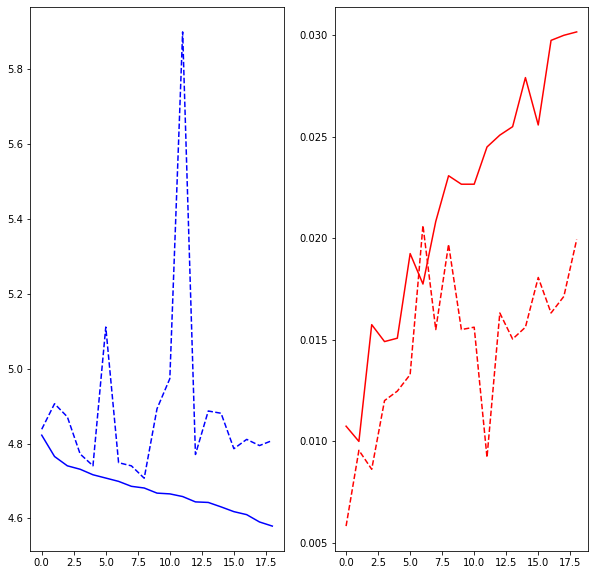

In [45]:
fig = plt.figure(figsize = (10,10))

plt.subplot(1,2,1)
plt.plot(history_cam['loss'], 'b')
plt.plot(history_cam['val_loss'], 'b--')

plt.subplot(1,2,2)
plt.plot(history_cam['accuracy'], 'r')
plt.plot(history_cam['val_accuracy'], 'r--')
plt.show()

(255로 나누어 nomalize 수행) - 실수로 train만 255기준 normalization 진행하고, test는 정규 분포로 normalization 수행함

In [58]:
cam_model_path_1 = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model_1.h5'

In [59]:
# early stopping과 최적 파라미터 모델 저장 콜백 구현
checkpoint_cb = keras.callbacks.ModelCheckpoint(cam_model_path, save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history_cam_1 = cam_model.fit(
                ds_train_norm_1,
                steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_NUM),
                validation_steps=int(ds_info.splits['test'].num_examples/BATCH_NUM),
                epochs=EPOCHS,
                validation_data=ds_test_norm,
                verbose=1,
                callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/30
750/750 [==============================] - 162s 206ms/step - loss: 4.7990 - accuracy: 0.0150 - val_loss: 17.2673 - val_accuracy: 0.0048
Epoch 2/30
750/750 [==============================] - 155s 207ms/step - loss: 4.5566 - accuracy: 0.0271 - val_loss: 5.3784 - val_accuracy: 0.0126
Epoch 3/30
750/750 [==============================] - 155s 207ms/step - loss: 4.2169 - accuracy: 0.0482 - val_loss: 8.3749 - val_accuracy: 0.0124
Epoch 4/30
750/750 [==============================] - 156s 207ms/step - loss: 3.9140 - accuracy: 0.0847 - val_loss: 7.1234 - val_accuracy: 0.0078
Epoch 5/30
750/750 [==============================] - 155s 207ms/step - loss: 3.6023 - accuracy: 0.1273 - val_loss: 9.1733 - val_accuracy: 0.0073
Epoch 6/30
750/750 [==============================] - 155s 207ms/step - loss: 3.2425 - accuracy: 0.1913 - val_loss: 12.5857 - val_accuracy: 0.0075
Epoch 7/30
750/750 [==============================] - 154s 206ms/step - loss: 2.3277 - accuracy: 0.3733 - val_loss: 21.909

In [61]:
history_cam_df_1 = pd.DataFrame(history_cam_1.history)
history_cam_csv_1 = 'history_cam_1.csv'
with open(history_cam_csv_1, mode='w') as f:
    history_cam_df_1.to_csv(f)

In [62]:
history_cam_1 =  pd.read_csv("history_cam_1.csv")

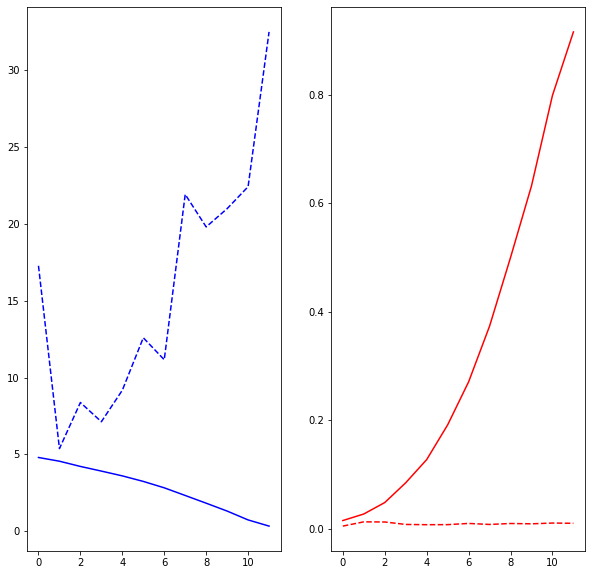

In [64]:
fig = plt.figure(figsize = (10,10))

plt.subplot(1,2,1)
plt.plot(history_cam_1['loss'], 'b')
plt.plot(history_cam_1['val_loss'], 'b--')

plt.subplot(1,2,2)
plt.plot(history_cam_1['accuracy'], 'r')
plt.plot(history_cam_1['val_accuracy'], 'r--')
plt.show()

test의 normalization을 train과 다르하여 test의 경우 학습이 거의 진행되지 않았습니다.

(255로 나누어 nomalize 재수행)

In [71]:
cam_model_path_2 = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model_2.h5'

In [72]:
# early stopping과 최적 파라미터 모델 저장 콜백 구현
checkpoint_cb = keras.callbacks.ModelCheckpoint(cam_model_path_2, save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history_cam_2 = cam_model.fit(
                ds_train_norm_1,
                steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_NUM),
                validation_steps=int(ds_info.splits['test'].num_examples/BATCH_NUM),
                epochs=EPOCHS,
                validation_data=ds_test_norm_1,
                verbose=1,
                callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/30
750/750 [==============================] - 156s 203ms/step - loss: 4.1963 - accuracy: 0.0554 - val_loss: 4.3332 - val_accuracy: 0.0475
Epoch 2/30
750/750 [==============================] - 153s 204ms/step - loss: 3.8944 - accuracy: 0.0899 - val_loss: 3.9431 - val_accuracy: 0.0857
Epoch 3/30
750/750 [==============================] - 153s 204ms/step - loss: 3.5784 - accuracy: 0.1334 - val_loss: 4.3633 - val_accuracy: 0.0870
Epoch 4/30
750/750 [==============================] - 153s 203ms/step - loss: 3.2037 - accuracy: 0.2014 - val_loss: 4.3647 - val_accuracy: 0.0998
Epoch 5/30
750/750 [==============================] - 153s 204ms/step - loss: 0.3222 - accuracy: 0.9093 - val_loss: 5.1585 - val_accuracy: 0.2259
Epoch 14/30
750/750 [==============================] - 153s 204ms/step - loss: 0.0884 - accuracy: 0.9797 - val_loss: 4.3501 - val_accuracy: 0.2739
Epoch 15/30
750/750 [==============================] - 153s 204ms/step - loss: 0.0730 - accuracy: 0.9835 - val_loss: 4.8985

In [73]:
history_cam_df_2 = pd.DataFrame(history_cam_2.history)
history_cam_csv_2 = 'history_cam_2.csv'
with open(history_cam_csv_2, mode='w') as f:
    history_cam_df_2.to_csv(f)

In [74]:
history_cam_2 =  pd.read_csv("history_cam_2.csv")

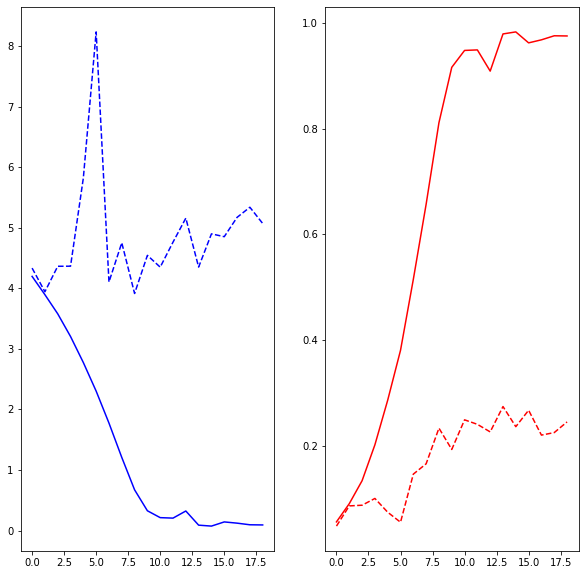

In [75]:
fig = plt.figure(figsize = (10,10))

plt.subplot(1,2,1)
plt.plot(history_cam_2['loss'], 'b')
plt.plot(history_cam_2['val_loss'], 'b--')

plt.subplot(1,2,2)
plt.plot(history_cam_2['accuracy'], 'r')
plt.plot(history_cam_2['val_accuracy'], 'r--')
plt.show()

(optimizer를 SGD로 변경하여 재학습)

In [25]:
cam_model_path_3 = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model_3.h5'

In [26]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [29]:
# early stopping과 최적 파라미터 모델 저장 콜백 구현
checkpoint_cb = keras.callbacks.ModelCheckpoint(cam_model_path_3, save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history_cam_3 = cam_model.fit(
                ds_train_norm_1,
                steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_NUM),
                validation_steps=int(ds_info.splits['test'].num_examples/BATCH_NUM),
                epochs=EPOCHS,
                validation_data=ds_test_norm_1,
                verbose=1,
                callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/30
750/750 [==============================] - 167s 207ms/step - loss: 2.1918 - accuracy: 0.4538 - val_loss: 3.7630 - val_accuracy: 0.1494


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/30
750/750 [==============================] - 154s 205ms/step - loss: 0.7199 - accuracy: 0.8016 - val_loss: 1.0501 - val_accuracy: 0.6898
Epoch 3/30
750/750 [==============================] - 154s 205ms/step - loss: 0.2235 - accuracy: 0.9547 - val_loss: 0.9491 - val_accuracy: 0.7280
Epoch 4/30
750/750 [==============================] - 154s 206ms/step - loss: 0.0686 - accuracy: 0.9935 - val_loss: 0.9124 - val_accuracy: 0.7428
Epoch 5/30
750/750 [==============================] - 154s 205ms/step - loss: 0.0301 - accuracy: 0.9989 - val_loss: 0.9175 - val_accuracy: 0.7434
Epoch 6/30
750/750 [==============================] - 154s 205ms/step - loss: 0.0203 - accuracy: 0.9990 - val_loss: 0.9359 - val_accuracy: 0.7402
Epoch 7/30
750/750 [==============================] - 169s 225ms/step - loss: 0.0148 - accuracy: 0.9993 - val_loss: 0.9417 - val_accuracy: 0.7420
Epoch 8/30
750/750 [==============================] - 154s 206ms/step - loss: 0.0106 - accuracy: 0.9998 - val_loss: 0.9510 -

In [30]:
history_cam_df_3 = pd.DataFrame(history_cam_3.history)
history_cam_csv_3 = 'history_cam_3.csv'
with open(history_cam_csv_3, mode='w') as f:
    history_cam_df_3.to_csv(f)

In [31]:
history_cam_3 =  pd.read_csv("history_cam_3.csv")

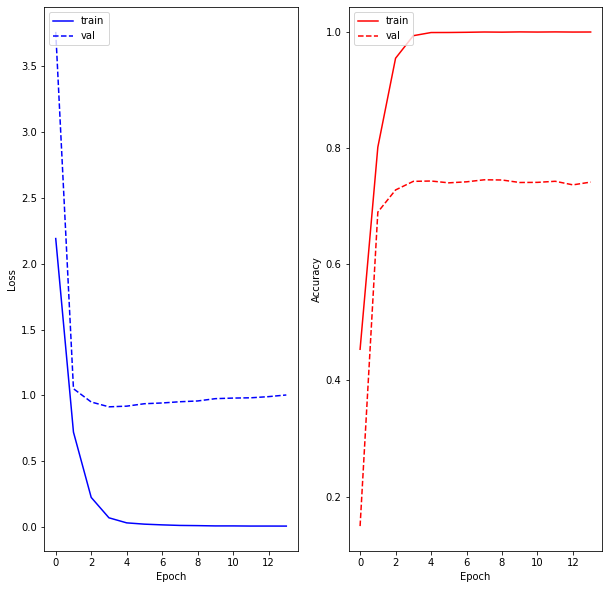

In [33]:
fig = plt.figure(figsize = (10,10))

plt.subplot(1,2,1)
plt.plot(history_cam_3['loss'], 'b')
plt.plot(history_cam_3['val_loss'], 'b--')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history_cam_3['accuracy'], 'r')
plt.plot(history_cam_3['val_accuracy'], 'r--')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','val'], loc='upper left')

plt.show()

In [65]:
def generate_cam(model, item):
    # image load
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    # image normalize
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # prediction 수행
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output,model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    print("conv_outputs :", conv_outputs.shape)
    print(conv_outputs)
    conv_outputs = conv_outputs[0, :, :, :]
    
    # class_weights 가져오기   
    
    class_weights = model.layers[-1].get_weights()
    print("class_weights : ", class_weights)
    class_weights = model.layers[-1].get_weights()[0]
    print("class_weights[0] : ", class_weights.shape)
    print(class_weights) 
    
    # cam_image 만들기
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 출력
        cam_image += w * conv_outputs[:, : , i]
    
    cam_image /= np.max(cam_image) # activation score를 normalize
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원본 이미지 크기로 resize
    
    return cam_image
    

In [66]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    
    merged_image = cv2,addWeighted(src1, alpha, src2, 1-alpha, 0.0)
    
    return merged_image

In [67]:
cam_image = generate_cam(cam_model, item)

conv_outputs : (1, 7, 7, 2048)
tf.Tensor(
[[[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   ...
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]]

  [[0.0000000e+00 0.0000000e+00 7.2260015e-03 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0.0000000e+00 0.0000000e+00]
   ...
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    0

In [ ]:
del cam_model

## Grad-CAM 구현하기
1. 이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.
2. 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.
3. 위에서 만든 이미지 visualize_cam_on_image() 함수로 이미지를 시각화해 보세요.

## 바운딩 박스 구하기
1. 제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어보세요.
2. 에서 얻은 바운딩 박스를 시각화해 보세요.

## IoU 구하기
1. 정답 바운딩 박스(ground truth) 와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수를 만들어 주세요.
2. CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 봅시다.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


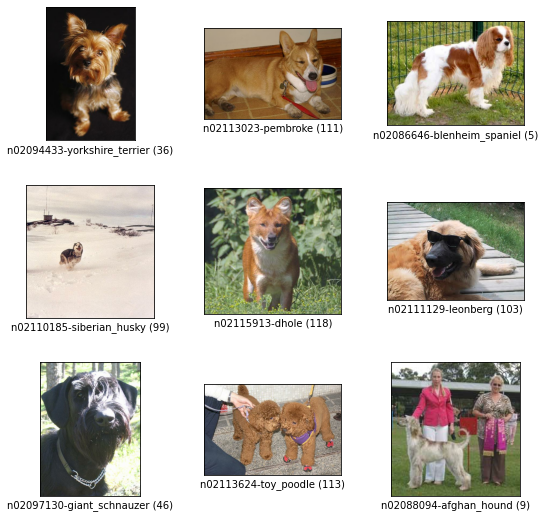

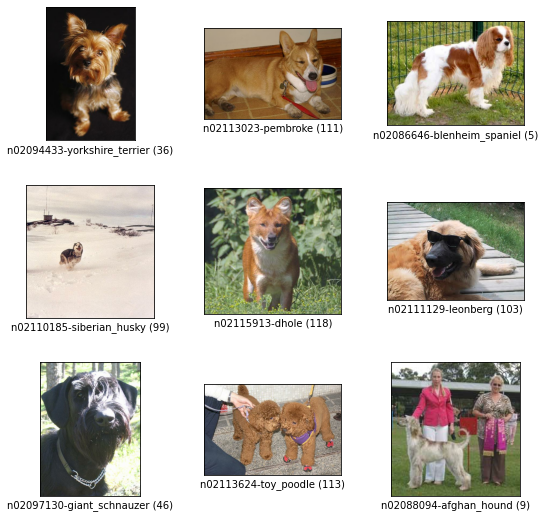

In [4]:
tfds.show_examples(ds_train, ds_info)

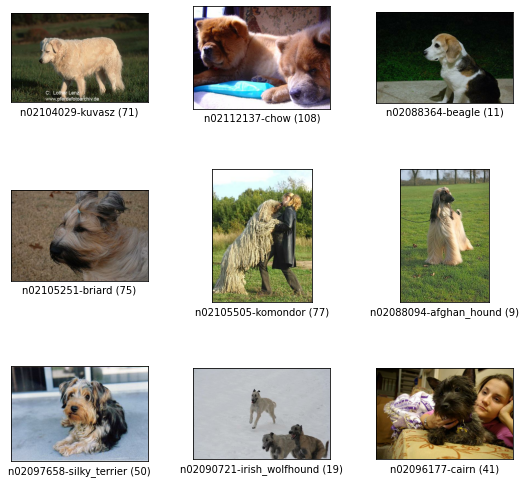

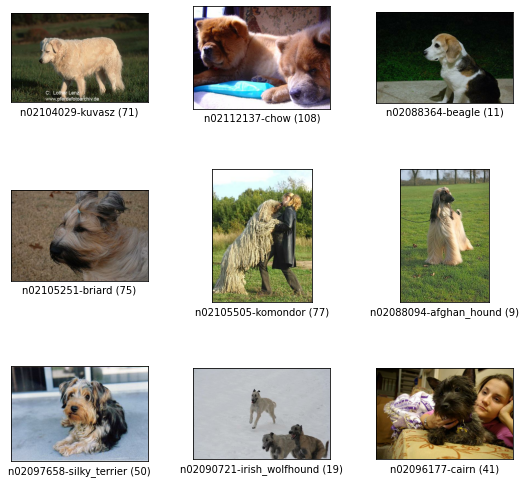

In [5]:
tfds.show_examples(ds_test, ds_info)

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 0s 0us/step


In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [9]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [11]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [12]:
epochs = 50

In [ ]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=epochs,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50
750/750 [==============================] - 191s 200ms/step - loss: 2.2111 - accuracy: 0.4495 - val_loss: 3.3936 - val_accuracy: 0.2077
Epoch 2/50
750/750 [==============================] - 153s 205ms/step - loss: 0.6994 - accuracy: 0.8119 - val_loss: 1.0721 - val_accuracy: 0.6815
Epoch 3/50
750/750 [==============================] - 154s 205ms/step - loss: 0.2206 - accuracy: 0.9548 - val_loss: 0.9485 - val_accuracy: 0.7188
Epoch 4/50
750/750 [==============================] - 153s 205ms/step - loss: 0.0640 - accuracy: 0.9942 - val_loss: 0.9083 - val_accuracy: 0.7355
Epoch 5/50
750/750 [==============================] - 153s 205ms/step - loss: 0.0275 - accuracy: 0.9986 - val_loss: 0.8989 - val_accuracy: 0.7415
Epoch 6/50
750/750 [==============================] - 153s 205ms/step - loss: 0.0202 - accuracy: 0.9994 - val_loss: 0.9387 - val_accuracy: 0.7330
Epoch 7/50
750/750 [==============================] - 153s 205ms/step - loss: 0.0369 - accuracy: 0.9977 - val_loss: 0.9679 -

In [ ]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model1.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

In [ ]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

In [ ]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [ ]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [ ]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

In [ ]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [ ]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

In [ ]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

In [ ]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [ ]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

In [ ]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

In [ ]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [ ]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [ ]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

In [ ]:
rect = get_bbox(cam_image)
rect

In [ ]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [ ]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [ ]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

In [ ]:
item['objects']['bbox']

In [ ]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [ ]:
get_iou(pred_bbox, item['objects']['bbox'][0])